

# Treinamento de Modelo LSTM para Previsão de Preços de Ações

## 1. Importação das Bibliotecas
Nesta seção, importamos todas as bibliotecas necessárias para o projeto.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import joblib  # Para salvar o scaler
import requests
from pandas.tseries.offsets import BDay # Para calcular dias úteis

## 2. Coleta e Pré-processamento dos Dados

### 2.1. Coleta de Dados via yfinance 
Vamos definir o símbolo da ação, o período e buscar os dados usando `yfinance`.

In [ ]:
SIMBOLO_ACAO = 'PETR4.SA' # Exemplo: Petrobras. Altere para a empresa desejada.
DATA_INICIO = '2018-01-01'
DATA_FIM = '2024-01-01' # Usar dados até o início de 2024 para treino/validação

print(f"Buscando dados para {SIMBOLO_ACAO} de {DATA_INICIO} a {DATA_FIM} via yfinance...")
dados = yf.download(SIMBOLO_ACAO, start=DATA_INICIO, end=DATA_FIM, progress=False)

if dados.empty:
    raise Exception(f"Nenhum dado encontrado para {SIMBOLO_ACAO} via yfinance. Verifique o símbolo ou o período.")

print("Dados coletados via yfinance:")
print(dados.head())
print(f"\nFormato dos dados (yfinance): {dados.shape}")

if 'Close' not in dados.columns or dados.empty:
    raise Exception("A coluna 'Close' não foi encontrada ou os dados estão vazios. Verifique a coleta de dados.")

dados_fechamento = dados['Close'].values.reshape(-1, 1)


Buscando dados para PETR4.SA de 2018-01-01 a 2024-01-01 via yfinance...
Dados coletados via yfinance:
Price          Close      High       Low      Open    Volume
Ticker      PETR4.SA  PETR4.SA  PETR4.SA  PETR4.SA  PETR4.SA
Date                                                        
2018-01-02  4.835752  4.835752  4.730564  4.730564  33461800
2018-01-03  4.879580  4.885423  4.783157  4.818219  55940900
2018-01-04  4.888345  4.955549  4.856205  4.902955  37064900
2018-01-05  4.917565  4.926331  4.841595  4.879580  26958200
2018-01-08  4.976004  4.976004  4.882502  4.891268  28400000

Formato dos dados (yfinance): (1487, 5)


array([[ 4.83575201],
       [ 4.87957954],
       [ 4.88834524],
       ...,
       [29.99962616],
       [30.02372932],
       [29.92729759]])

### 2.2. Normalização dos Dados
Redes neurais geralmente performam melhor com dados normalizados. Usaremos MinMaxScaler.

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
dados_normalizados = scaler.fit_transform(dados_fechamento)

# Salvar o scaler para uso posterior na API de deploy
joblib.dump(scaler, 'min_max_scaler.gz')
print("\nScaler salvo como 'min_max_scaler.gz'")


Scaler salvo como 'min_max_scaler.gz'


### 2.3. Criação de Sequências para LSTM
LSTM espera dados em formato de sequências (janelas de tempo).

In [4]:
def criar_sequencias(dados, tamanho_janela):
    """
    Cria sequências X (features) e y (labels) para o modelo LSTM.
    Args:
        dados (np.array): Array dos dados normalizados.
        tamanho_janela (int): Número de passos no tempo para cada sequência.
    Returns:
        (np.array, np.array): Tupla contendo X e y.
    """
    X, y = [], []
    for i in range(len(dados) - tamanho_janela):
        X.append(dados[i:(i + tamanho_janela), 0])
        y.append(dados[i + tamanho_janela, 0])
    return np.array(X), np.array(y)

TAMANHO_JANELA = 60  # Usar os últimos 60 dias para prever o próximo
X, y = criar_sequencias(dados_normalizados, TAMANHO_JANELA)

# Reshape X para o formato esperado pela LSTM: [amostras, passos_no_tempo, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(f"\nFormato de X (sequências de entrada): {X.shape}")
print(f"Formato de y (saída esperada): {y.shape}")



Formato de X (sequências de entrada): (1427, 60, 1)
Formato de y (saída esperada): (1427,)


### 2.4. Divisão em Dados de Treino e Teste
Separamos os dados para treinar e validar o modelo.

In [5]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=False) # shuffle=False para séries temporais

print(f"\nFormato de X_treino: {X_treino.shape}, y_treino: {y_treino.shape}")
print(f"Formato de X_teste: {X_teste.shape}, y_teste: {y_teste.shape}")

# Guardar as datas correspondentes a y_teste para visualização e referência
datas_teste = dados.index[len(dados) - len(y_teste):]


Formato de X_treino: (1141, 60, 1), y_treino: (1141,)
Formato de X_teste: (286, 60, 1), y_teste: (286,)


## 3. Desenvolvimento do Modelo LST
### 3.1. Construção da Arquitetura do Modelo
Definimos as camadas da rede LSTM.

In [6]:
modelo = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(X_treino.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=100, return_sequences=True),
    Dropout(0.2),
    LSTM(units=100),
    Dropout(0.2),
    Dense(units=1) # Camada de saída com 1 neurônio para prever o preço
])

c:\Users\walve\Documents\FIAP\Fase 4\Tech_Challenge_4\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 3.2. Compilação do Modelo
Definimos o otimizador e a função de perda.

In [7]:
modelo.compile(optimizer='adam', loss='mean_squared_error')
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,701 (787.89 KB)

 Trainable params: 201,701 (787.89 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Treinamento do Modelo

### 4.1. Callbacks para Treinamento
Usaremos EarlyStopping para evitar overfitting e ModelCheckpoint para salvar o melhor modelo.


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('melhor_modelo_lstm.keras', save_best_only=True, monitor='val_loss') # Alterado de .h5 para .keras

print("\nIniciando o treinamento do modelo...")
historico = modelo.fit(
    X_treino,
    y_treino,
    epochs=100, # Número máximo de épocas
    batch_size=32,
    validation_data=(X_teste, y_teste),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print("Treinamento concluído.")



Iniciando o treinamento do modelo...
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - loss: 0.0160 - val_loss: 0.0021
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 8.9603e-04 - val_loss: 0.0017
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 8.3250e-04 - val_loss: 0.0022
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 8.4366e-04 - val_loss: 0.0013
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 8.8056e-04 - val_loss: 0.0032
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 8.9391e-04 - val_loss: 0.0019
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 8.9397e-04 - val_l

### 4.2. Plotar Histórico de Treinamento

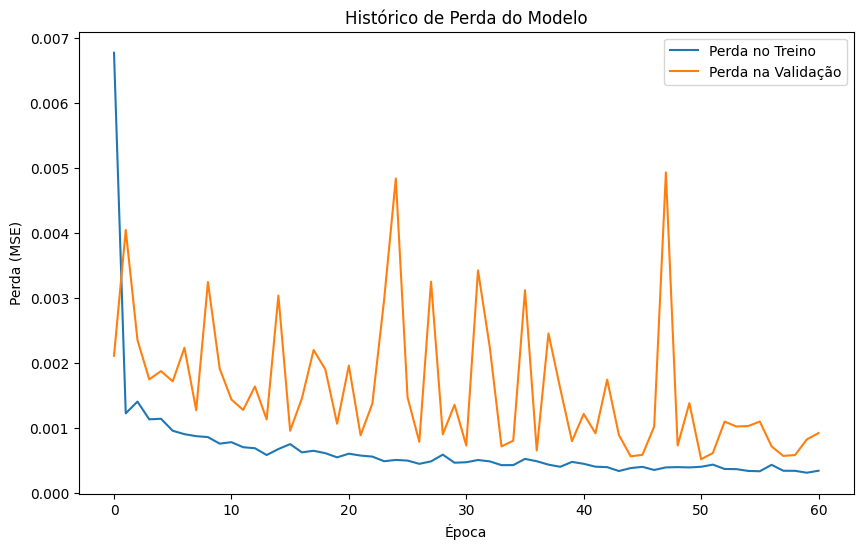

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(historico.history['loss'], label='Perda no Treino')
plt.plot(historico.history['val_loss'], label='Perda na Validação')
plt.title('Histórico de Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda (MSE)')
plt.legend()
plt.show()

## 5. Avaliação do Modelo
### 5.1. Carregar o Melhor Modelo Salvo (se necessário)

In [10]:
# O callback ModelCheckpoint já deve ter restaurado os melhores pesos se EarlyStopping foi acionado,
# ou podemos carregar explicitamente o modelo salvo.
# modelo = tf.keras.models.load_model('melhor_modelo_lstm.keras') # Descomente se precisar carregar


### 5.2. Fazer Previsões com Dados de Teste

In [11]:
previsoes_normalizadas = modelo.predict(X_teste)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


### 5.3. Desnormalizar as Previsões e os Dados Reais
Precisamos reverter a normalização para comparar com os preços originais.

In [12]:
previsoes = scaler.inverse_transform(previsoes_normalizadas)
y_teste_reais = scaler.inverse_transform(y_teste.reshape(-1, 1))

### 5.4. Calcular Métricas de Avaliação
MAE (Mean Absolute Error), RMSE (Root Mean Squared Error), MAPE (Mean Absolute Percentage Error)


In [13]:
mae = mean_absolute_error(y_teste_reais, previsoes)
rmse = np.sqrt(mean_squared_error(y_teste_reais, previsoes))

# Calcular MAPE com cuidado para evitar divisão por zero
y_teste_reais_flat = y_teste_reais.flatten()
previsoes_flat = previsoes.flatten()
# Filtrar zeros de y_teste_reais_flat para evitar divisão por zero no MAPE
non_zero_mask = y_teste_reais_flat != 0
mape = np.mean(np.abs((y_teste_reais_flat[non_zero_mask] - previsoes_flat[non_zero_mask]) / y_teste_reais_flat[non_zero_mask])) * 100

print(f"\n--- Métricas de Avaliação ---")
print(f"MAE (Mean Absolute Error): R$ {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): R$ {rmse:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")


--- Métricas de Avaliação ---
MAE (Mean Absolute Error): R$ 0.47
RMSE (Root Mean Squared Error): R$ 0.60
MAPE (Mean Absolute Percentage Error): 2.43%


### 5.5. Visualizar Previsões vs. Dados Reais

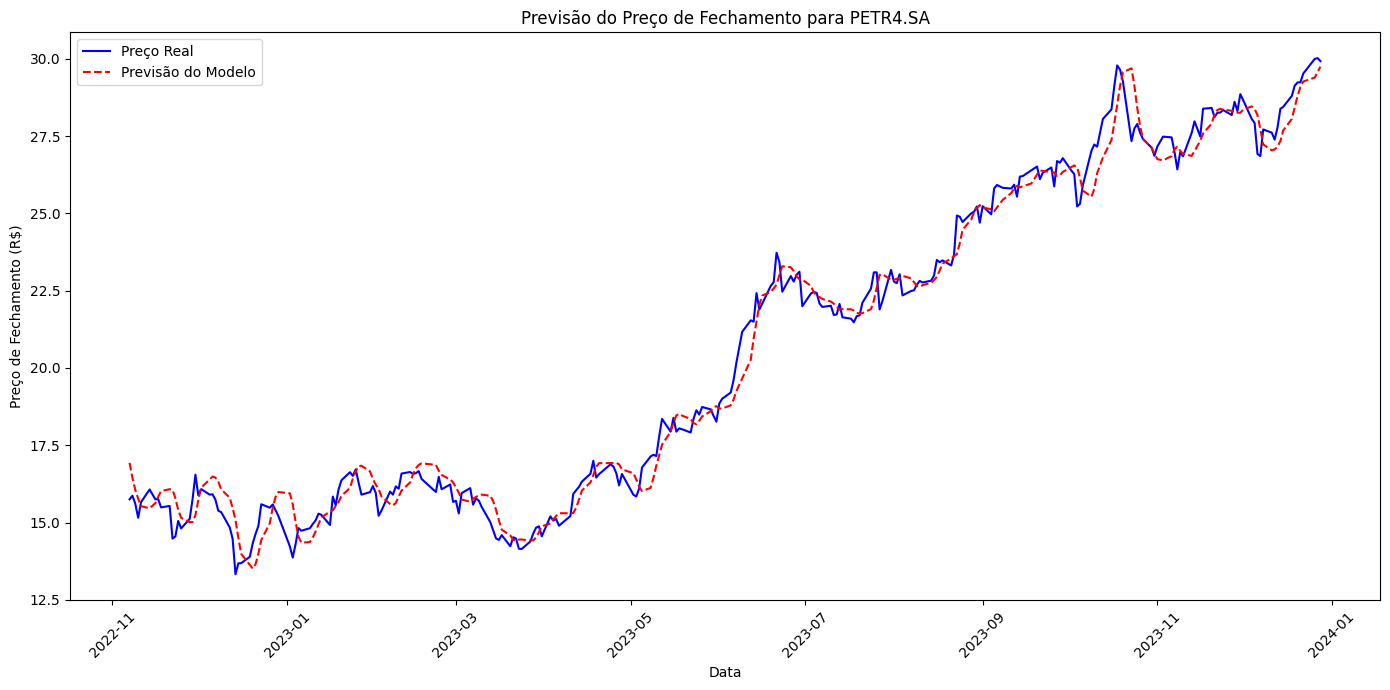

In [14]:
plt.figure(figsize=(14, 7))
# Usar as datas reais do conjunto de teste para o eixo X
plt.plot(datas_teste, y_teste_reais, color='blue', label='Preço Real')
plt.plot(datas_teste, previsoes, color='red', linestyle='--', label='Previsão do Modelo')
plt.title(f'Previsão do Preço de Fechamento para {SIMBOLO_ACAO}')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (R$)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5.6. Comparar Última Previsão do Conjunto de Teste com Valor Real Correspondente

In [15]:
ultima_data_teste = datas_teste[-1]
ultimo_preco_real_teste = y_teste_reais[-1, 0]
ultima_previsao_teste = previsoes[-1, 0]

print(f"\n--- Comparação da Última Previsão no Conjunto de Teste ---")
print(f"Data da Última Previsão/Real no Teste: {ultima_data_teste.strftime('%Y-%m-%d')}")
print(f"Último Preço Real no Teste: R$ {ultimo_preco_real_teste:.2f}")
print(f"Última Previsão do Modelo no Teste: R$ {ultima_previsao_teste:.2f}")
print(f"Diferença Absoluta: R$ {abs(ultimo_preco_real_teste - ultima_previsao_teste):.2f}")



--- Comparação da Última Previsão no Conjunto de Teste ---
Data da Última Previsão/Real no Teste: 2023-12-28
Último Preço Real no Teste: R$ 29.93
Última Previsão do Modelo no Teste: R$ 29.75
Diferença Absoluta: R$ 0.18


## 6. Salvamento do Modelo Final

In [16]:
# O modelo já foi salvo como 'melhor_modelo_lstm.keras' pelo ModelCheckpoint.
# Se desejar salvar com outro nome ou após mais algum ajuste:
# modelo.save('modelo_lstm_final.keras')
print("\nModelo final (melhor_modelo_lstm.keras) e scaler (min_max_scaler.gz) estão salvos.")


Modelo final (melhor_modelo_lstm.keras) e scaler (min_max_scaler.gz) estão salvos.


## 7. Prever um Novo Dia (Além do Dataset Original) e Comparar com o Real (Exemplo Avançado)
Esta seção mostra como prever um dia futuro e depois buscar o valor real para comparação.

In [25]:
print("\n--- Exemplo: Previsão para o Próximo Dia Útil Após DATA_FIM e Comparação ---")

# 1. Pegar os últimos 'TAMANHO_JANELA' dias do *dataset original completo*
ultimos_dados_conhecidos = dados['Close'].values[-TAMANHO_JANELA:]

# 2. Normalizar esses dados usando o scaler já treinado
ultimos_dados_normalizados = scaler.transform(ultimos_dados_conhecidos.reshape(-1, 1))

# 3. Remodelar para o formato da LSTM [amostras, passos_no_tempo, features]
input_para_previsao = np.reshape(ultimos_dados_normalizados, (1, TAMANHO_JANELA, 1))

# 4. Fazer a previsão com o modelo treinado
previsao_proximo_dia_normalizada = modelo.predict(input_para_previsao)

# 5. Desnormalizar a previsão
previsao_proximo_dia = scaler.inverse_transform(previsao_proximo_dia_normalizada)
data_da_previsao = pd.to_datetime(DATA_FIM) + BDay(1) # Próximo dia útil

# Converter a previsão para float antes de imprimir
previsao_para_print = float(previsao_proximo_dia[0,0])
print(f"Previsão do modelo para {SIMBOLO_ACAO} em {data_da_previsao.strftime('%Y-%m-%d')}: R$ {previsao_para_print:.2f}")

# 6. Buscar o dado real para o dia da previsão
try:
    dados_reais_proximo_dia = yf.download(SIMBOLO_ACAO, start=data_da_previsao.strftime('%Y-%m-%d'), end=(data_da_previsao + BDay(1)).strftime('%Y-%m-%d'), progress=False)
    if not dados_reais_proximo_dia.empty:
        # valor_real_scalar é a Series de um único elemento que causa o aviso
        valor_real_scalar = dados_reais_proximo_dia['Close'].iloc[0] 

        # CORREÇÃO: Aplicar .iloc[0] à Series valor_real_scalar antes de converter para float
        valor_real_para_print = float(valor_real_scalar.iloc[0]) 

        print(f"Valor de Fechamento Real em {data_da_previsao.strftime('%Y-%m-%d')}: R$ {valor_real_para_print:.2f}")

        # Calcular diferença usando os valores float
        diferenca_absoluta = abs(valor_real_para_print - previsao_para_print)
        print(f"Diferença Absoluta: R$ {diferenca_absoluta:.2f}")
    else:
        print(f"Não foi possível obter o dado real de fechamento para {data_da_previsao.strftime('%Y-%m-%d')}.")
except Exception as e:
    print(f"Erro ao buscar dado real para {data_da_previsao.strftime('%Y-%m-%d')}: {e}")




--- Exemplo: Previsão para o Próximo Dia Útil Após DATA_FIM e Comparação ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Previsão do modelo para PETR4.SA em 2024-01-02: R$ 29.83
Valor de Fechamento Real em 2024-01-02: R$ 30.34
Diferença Absoluta: R$ 0.50


## 8. Exemplo de como carregar e usar o modelo para uma nova previsão (opcional)
Esta parte seria mais relevante para a API de deploy.

In [ ]:
# Carregar o modelo e o scaler
# modelo_carregado = tf.keras.models.load_model('melhor_modelo_lstm.keras')
# scaler_carregado = joblib.load('min_max_scaler.gz')

# Suponha que 'ultimos_dados' seja um array numpy com os últimos 'TAMANHO_JANELA' preços de fechamento
# ultimos_dados = dados_fechamento[-TAMANHO_JANELA:].reshape(1, -1) # Pegando os últimos dados reais como exemplo
# ultimos_dados_normalizados = scaler_carregado.transform(ultimos_dados.reshape(-1,1)) # Normalizar
# ultimos_dados_formatados = np.reshape(ultimos_dados_normalizados, (1, TAMANHO_JANELA, 1)) # Formato LSTM

# previsao_nova_normalizada = modelo_carregado.predict(ultimos_dados_formatados)
# previsao_nova = scaler_carregado.inverse_transform(previsao_nova_normalizada)
# print(f"\nExemplo de nova previsão (para o próximo dia): R$ {previsao_nova[0,0]:.2f}")

print("\n--- Fim do Notebook ---")